# Data ETL Process

### This notebook reads the data from two data libraries, one with the full transaction history of al Crypto Punk ETFs, and another library of image (.png) files for each individual Crypto Punk. The ETL process creates __ tables for the project:

### * crypto_punks_df (Pandas dataframe)
### * accessories_df (Pandas dataframe)
### * crypto_punks_mdb (MongoDB database)
### * < nombre del collection en crypto_punks_mdb> (Mongo DB collection)

#### Please refer to the project ERD for details on the data tables and structures.

In [1]:
# Import Dependencies

import os
import sqlite3
import requests
import json
import pymongo
from pymongo import MongoClient

# Import nfts.dataset
# Import data manipulation libraries
import numpy as np
import pandas as pd
import random

# Import ML libraries
from scipy.optimize import curve_fit
from scipy.special import zeta

# Import image and plotting libraries
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns




## Read the Data File

In [2]:
# Read the trading data json file
df = pd.read_json("Data/txn_history-2021-10-07.jsonl", lines=True)
df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [3]:
# Inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167492 entries, 0 to 167491
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   txn_type             167492 non-null  object        
 1   from                 167492 non-null  object        
 2   to                   167492 non-null  object        
 3   date                 167492 non-null  datetime64[ns]
 4   timestamp            167492 non-null  datetime64[ns]
 5   source               167492 non-null  object        
 6   eth                  127542 non-null  float64       
 7   punk_id              167492 non-null  int64         
 8   from_wallet_address  419 non-null     object        
 9   to_wallet_address    419 non-null     object        
 10  type                 167492 non-null  object        
 11  accessories          167492 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 15.3

In [4]:
# Fill nan eth values with cero
df["eth"] = df["eth"].fillna(0)
df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [5]:
# Get a count of the unique Crypto Punk NFT type
print(df["type"].value_counts())

[Male]      104154
[Female]     59873
[Zombie]      2251
[Ape]          787
[Alien]        427
Name: type, dtype: int64


## Create a Data Table For the Unique Punk IDs and Relevant Features (Type, Accessories)

In [6]:
# Create a copy of the dataframe with only the columns describing the Crypto_punk nfts with unique values for punk_id
temp_df = df
temp_df = temp_df.drop(columns=['txn_type', 'from', 'to', 'date', 'timestamp', 'source', 'eth', 'from_wallet_address', 'to_wallet_address'])

# Convert the 'type' object to string
temp_df['type'] = temp_df['type'].astype('str')
temp_df['accessories'] = temp_df['accessories'].astype('str')

# Remove the brackets from the 'type'
for row in range(len(temp_df)):
    
    type = temp_df.at[row,'type']
    # index each string to exclude the first two and last two characters (brackets and quotes)
    clean_type = type[2:-2]
    temp_df.at[row,'type'] = clean_type
    
    #accessories = temp_df.at[row,'accessories']
    #clean_accessories = accessories[2:-2]
    #print(clean_accessories)
    #temp_df.at[row,'accessories'] = clean_accessories

crypto_punks_df = temp_df.drop_duplicates()
crypto_punks_df

,punk_id,type,accessories
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']"
41,1,Male,"['Smile', 'Mohawk']"
104,2,Female,['Wild Hair']
134,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']"
151,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']"
...,...,...,...
167357,9995,Female,"['Purple Eye Shadow', 'Straight Hair Dark']"
167364,9996,Male,"['Cigarette', 'Earring', 'Crazy Hair', 'Smile']"
167369,9997,Zombie,"['Front Beard', 'Cap Forward']"
167412,9998,Female,"['Wild White Hair', 'Black Lipstick', 'Clown E..."


In [7]:
# Reset the index to the same dataframe withoug adding a new column with the old index information
crypto_punks_df.reset_index(drop=True, inplace=True)
crypto_punks_df

,punk_id,type,accessories
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']"
1,1,Male,"['Smile', 'Mohawk']"
2,2,Female,['Wild Hair']
3,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']"
4,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']"
...,...,...,...
9995,9995,Female,"['Purple Eye Shadow', 'Straight Hair Dark']"
9996,9996,Male,"['Cigarette', 'Earring', 'Crazy Hair', 'Smile']"
9997,9997,Zombie,"['Front Beard', 'Cap Forward']"
9998,9998,Female,"['Wild White Hair', 'Black Lipstick', 'Clown E..."


In [8]:
crypto_punks_df.dtypes

punk_id         int64
type           object
accessories    object
dtype: object

In [9]:
# Get a count of the unique Crypto Punk NFT type
print(crypto_punks_df['type'].value_counts())

Male      6039
Female    3840
Zombie      88
Ape         24
Alien        9
Name: type, dtype: int64


## Create a Data Table for Cataloging the Unique Accessories

In [10]:
# Create a list of the individual accessories
# Capture all individual types and accessories and store them in a their respective lists
accessories_list =[]

# Loop through the dataframe
for row in range(len(df)):

    # Add a new field with the count of accessories
    accessory_count = len(df.at[row,"accessories"])
    df.at[row,"accessory_count"]=accessory_count
    
    # Add each new accessory description to a list of unique values
    for i in df.at[row,"accessories"]:
        
        if i not in accessories_list:
            accessories_list.append(i)

# Print all the unique accessories
print("There are "+str(len(accessories_list))+" distinct accessories:")
print(accessories_list)

There are 87 distinct accessories:
['Green Eye Shadow', 'Earring', 'Blonde Bob', 'Smile', 'Mohawk', 'Wild Hair', 'Nerd Glasses', 'Pipe', 'Big Shades', 'Goat', 'Purple Eye Shadow', 'Half Shaved', 'Do-rag', 'Wild White Hair', 'Spots', 'Clown Eyes Blue', 'Messy Hair', 'Luxurious Beard', 'Clown Nose', 'Police Cap', 'Big Beard', 'Blue Eye Shadow', 'Black Lipstick', 'Clown Eyes Green', 'Straight Hair Dark', 'Blonde Short', 'Purple Lipstick', 'Straight Hair Blonde', 'Pilot Helmet', 'Hot Lipstick', 'Regular Shades', 'Stringy Hair', 'Small Shades', 'Frown', 'Eye Mask', 'Muttonchops', 'Bandana', 'Horned Rim Glasses', 'Crazy Hair', 'Classic Shades', 'Handlebars', 'Mohawk Dark', 'Dark Hair', 'Peak Spike', 'Normal Beard Black', 'Cap', 'VR', 'Frumpy Hair', 'Cigarette', 'Normal Beard', 'Red Mohawk', 'Shaved Head', 'Chinstrap', 'Mole', 'Knitted Cap', 'Fedora', 'Shadow Beard', 'Straight Hair', 'Hoodie', 'Eye Patch', 'Headband', 'Cowboy Hat', 'Tassle Hat', '3D Glasses', 'Mustache', 'Vape', 'Choker', 'Pi

In [11]:
# Create a dataframe from the list
accessories_df = pd.DataFrame(accessories_list)
accessories_df

,0
0,Green Eye Shadow
1,Earring
2,Blonde Bob
3,Smile
4,Mohawk
...,...
82,Orange Side
83,Wild Blonde
84,Buck Teeth
85,Top Hat


In [12]:
# Rename the first column
accessories_df.rename(columns={0: "accessory"}, inplace=True)
accessories_df

,accessory
0,Green Eye Shadow
1,Earring
2,Blonde Bob
3,Smile
4,Mohawk
...,...
82,Orange Side
83,Wild Blonde
84,Buck Teeth
85,Top Hat


In [13]:
# Add a new column for count and initialize it to cero
for row in range(len(accessories_df)):
    accessories_df["counts"]=0
    
accessories_df

,accessory,counts
0,Green Eye Shadow,0
1,Earring,0
2,Blonde Bob,0
3,Smile,0
4,Mohawk,0
...,...,...
82,Orange Side,0
83,Wild Blonde,0
84,Buck Teeth,0
85,Top Hat,0


In [14]:
# Loop through the crypto punk id's to establish a count of all the accessories    
for row in range(len(crypto_punks_df)):

    # read the string of individual accessories
    individual_accessory = crypto_punks_df.at[row,"accessories"]
    
    # clean the string by removing special characters
    characters_to_remove="[']"
    for character in characters_to_remove:
        individual_accessory = individual_accessory.replace(character, "")
    
    # convert the string back to a list
    individual_list = list(individual_accessory.split(", "))
    
    # loop through the individual accessories associated with the punk_id
    for accessory in individual_list:
        
        # look for the index of the accessory in the accessories_df and add to the count
        accessory_index = accessories_df.index[accessories_df['accessory']==accessory]
        accessories_df.at[accessory_index,'counts']=accessories_df.loc[accessory_index,'counts']+1
        
accessories_df

,accessory,counts
0,Green Eye Shadow,271
1,Earring,2459
2,Blonde Bob,147
3,Smile,238
4,Mohawk,441
...,...,...
82,Orange Side,68
83,Wild Blonde,144
84,Buck Teeth,78
85,Top Hat,115


In [15]:
# Sort the counts in descending order
sorted_accessories_df = accessories_df.sort_values(['counts'], ascending=False)
sorted_accessories_df

,accessory,counts
1,Earring,2459
48,Cigarette,961
29,Hot Lipstick,696
26,Purple Lipstick,655
53,Mole,644
...,...,...
82,Orange Side,68
71,Tiara,55
28,Pilot Helmet,54
66,Choker,48


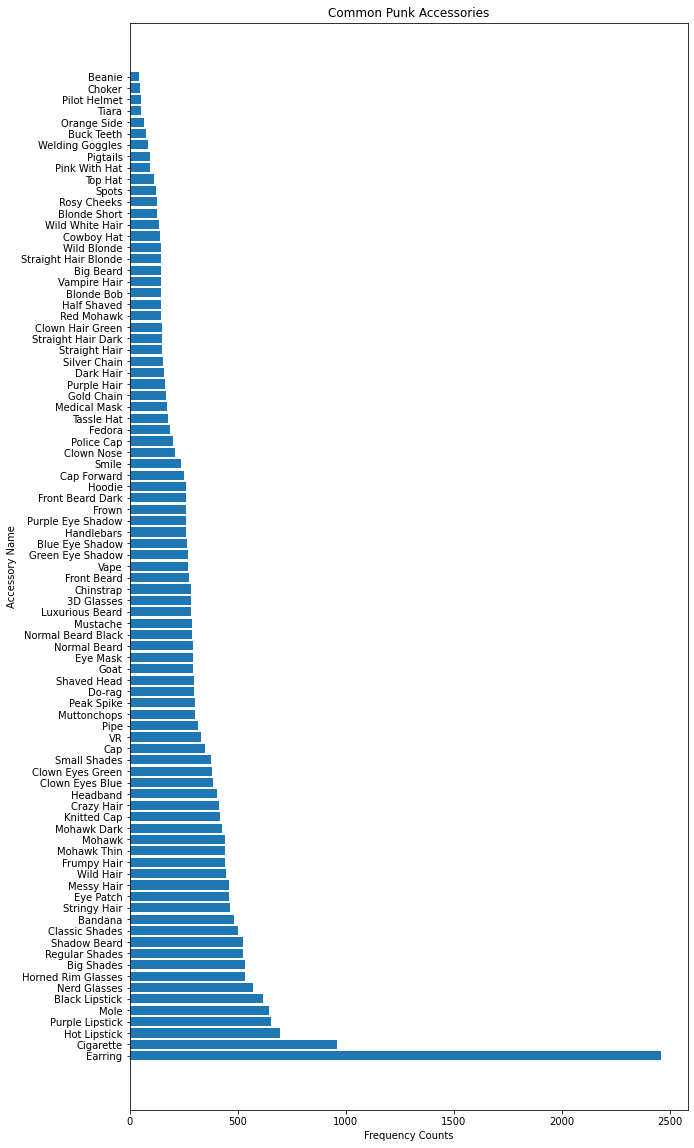

In [16]:
# Plot the frequency of the accessories counts
fig = plt.figure(figsize=(10,20))
plt.barh(sorted_accessories_df['accessory'], sorted_accessories_df['counts'])
plt.title('Common Punk Accessories')
plt.xlabel('Frequency Counts')
plt.ylabel('Accessory Name')
plt.show()

## Inspect a Sample of the Image Files

<function matplotlib.pyplot.show(close=None, block=None)>

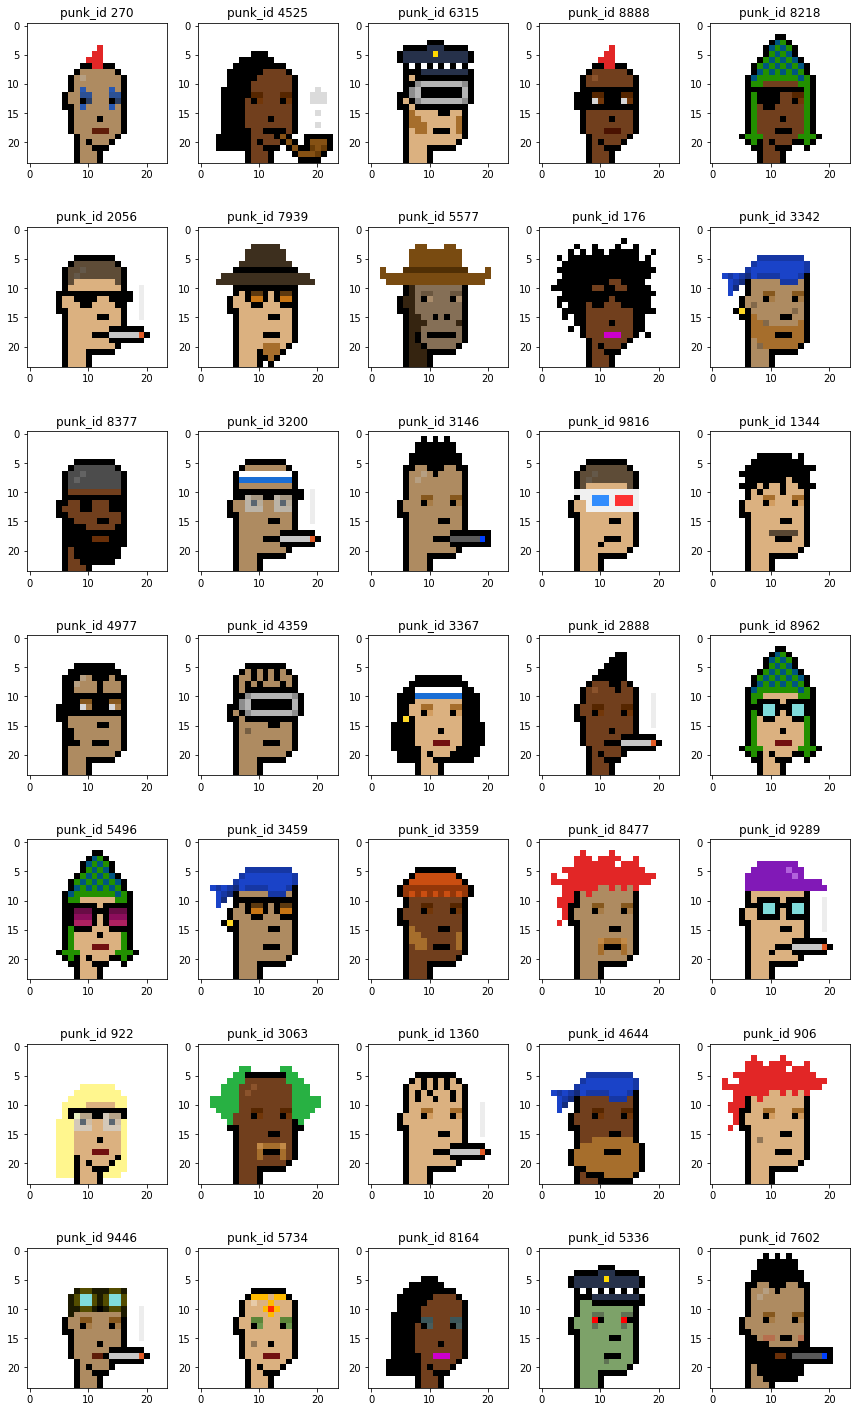

In [17]:
# Inspect a random set of 35 images in a 5 by 7 grid to better
# understand accessory features

# create plot
plt.figure(0, figsize=(12,20))

# Initialize variables
cpt = 0
pic_size = 24

# Loop for each row to plot
for n in range(7):

    # Loop for each column to plot
    for i in range(1,6):
        cpt=cpt + 1
        plt.subplot(7,5,cpt)
        
        # Select a random punk image and add it to the plot
        id = random.randint(0,9999)
        file_to_load = ("images/"+str(id)+".png")
        punk_image = Image.open(file_to_load)
        plt.imshow(punk_image)
        plt.title("punk_id "+str(id))
        
# Show the plotted images   
plt.tight_layout()
plt.show

## HOLA ALICIA Y GABRIELA, YA PUDE RESOLVER LO DE LA LISTA DE LOS ACCESSORIES Y LOS COUNTS. AHORA FALTA ASIGNARLAS A DISTINTAS CLASES, NO MAS DE SIETE U OCHO.

## CREO QUE PODRIAN SER ORGANIZADOS POR SECCION DE LA CARA: HAIR, HEADGEAR, EYES/GLASSES, NOSE/JAWLINE O ALGO ASI

## Add Image Bit Map for each Punk_ID

In [18]:
######################################################################
# Loop through the punk_ids, search for the corresponding image file, 
# convert the file to a bit map array, and store the array as a new 
# field in the crypto_punks_df
######################################################################

## ALICIA/GABRIELA: DEBEMOS VERIFICAR QUE EL CODIGO DE ABAJO ESTABLEZCA LA BASE DE DATOS EN MONGO Y CONVIERTA EL DATAFRAME QUE TENEMOS A UNA COLLECCION EN LA BASE DE DATOS DE MONGO.

In [19]:
# Convert the crypto_punks_df to a Mongo database so that we can
# store the image bit arrays

# Make a connection to Mongo with MongoClient
client = MongoClient("mongodb://localhost:27017/")

# Create the database
crypto_punks_mdb = client["crypto_punks_database"]

#####################################################################
# Remember that the equivalent of a "table" in a Mongo DB
# is a "collection", and the equivalent of a "row" is a "document"
# and a "column" is a "field"
#####################################################################

# Add the crypto_punks_df table as a MongoDB collection to
# out crypto_punks_mdb Mongo database
crypto_punks_mdb.collection.insert_many(crypto_punks_df.to_dict('records'))

## ALICIA/GABRIELA: HAY QUE MODIFICAR EL CODIGO DE ABAJO PARA QUE EN LUGAR DE TRATAR DE INSERTAR EL BITMAP AL DATAFRAME QUE TENEMOS (LO CUAL PANDAS NO MANEJA POR SER UN ARRAY), LO INSERTE AL COLLECTION DE MONGO CREADO EN LA CELDA ANTERIOR. ME PARECE QUE QUIZAS TENGAMOS QUE HACER LA NORMALIZACION (I.E. DIVIDIDIR LOS VALORES RGB ENTRE 255) DEL BIT MAP DENTRO DEL LOOP ANTES DE ADICIONARLO AL COLLECTION.

images/0.png
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


ValueError: could not broadcast input array from shape (24,24,4) into shape (24,4)

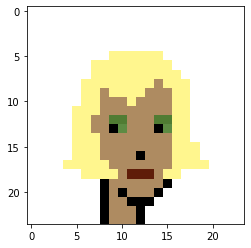

In [20]:
# Loop through the crypto punk IDs

# Test the for loop with only the first 10 ids. Replace the range for the final runs.
for row in range(10):#len(crypto_punks_df)):
    
    # read the id for each crypto punk
    id = (crypto_punks_df.loc[row,"punk_id"])
    
    # set the fillename based on that id
    file_to_open = ("images/"+str(id)+".png")
    
    # Read the RGB image for that id
    rgb_image = Image.open(file_to_open)
    
    # Convert the image to a bit array
    rgb_bit_map = np.asarray(rgb_image)
    
    # Use some print commands to check results. Eliminate these lines for the final runs.
    print(file_to_open)
    print(rgb_bit_map)
    img = plt.imshow(rgb_bit_map)
    
    
    #### De esta linea para arriba, todo funciona bien. Estuve realizando pruebas con solo los primeros
    #### 10 ids. Al parecer, cuando tratamos de guardar los arrays a la tabla, se genera un error. Debemos
    #### tratar de enteder qué lo causa, si es algo relacionado a Pandas dataframes, para entonces ver si
    #### es aquí donde necesitamos empezar a trabajar la data en MongoDB.
    
    # Store the array into a new column in the crypto_punks_df
    #### ESTA LINEA HAY QUE MODIFICARLA PARA QUE SUBA EL BIT MAP ARRAY
    #### AL COLLECTION DE MONGO DB EN LUGAR DE AL DATAFRAME
    crypto_punks_df.loc[row,"image bit array"] = rgb_bit_map

# Inspect the dataframe to check that the bit map arrays are included in the new column    
#### ESTA LINEA DEBEMOS CAMBIARLA PARA INSPECCIONAR EL COLLECTION EN 
#### MONGO DB UNA VEZ ADICIONADOS LOS BIT MAP ARRAYS
crypto_punks_df.head()

## ALICIA/GABRIELA: UNA VEZ TENGAMOS EL COLLECTION EN MONGO, NO ME QUEDA CLARO COMO APUNTAR A LA DATA PARA HACER EL TRAINING DE LA MISMA PARA EL MODELO DE ML.